In [1]:
from ase.lattice import bulk
from ase import Atoms
from ase import Atom
from ase.build import fcc111
from ase.lattice.hexagonal import *
from ase.lattice.cubic import SimpleCubic, FaceCenteredCubic
from ase.visualize import view
from ase.calculators.eam import EAM
from gpaw import GPAW,PW
import matplotlib.pyplot as plt
import math
import warnings
from IPython.display import Image
from math import exp
from decimal import Decimal
warnings.filterwarnings('ignore')

In [2]:
#MOLECULE VIEWER CODE
from IPython.display import HTML
def atoms_to_html(atoms):
    'Return the html representation the atoms object as string'

    from tempfile import NamedTemporaryFile

    with NamedTemporaryFile('r+', suffix='.html') as ntf:
        atoms.write(ntf.name, format='html')
        ntf.seek(0)
        html = ntf.read()
    return html

# Kristallvõre tasandid

Elektrokeemias on uuritavad elektroodipinnad tihti monokristallilised ning kindla Milleri indeksiga.

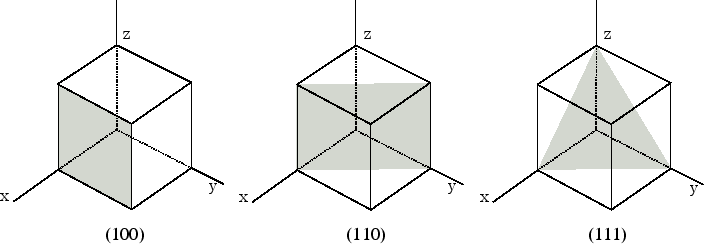

In [3]:
Image("miller.png")

Selles notebookis vaatame, kuidas selliseid pindu koostada. Ainult üks element kristalliseerub primtiivses kuubilises pakendis: poloonium. Üritame luua poloonium (0,1,1) tahu mudeli.

ase.lattice moodulis tuleb selleks anda juurde argument directions. directions argumendis defineeritakse kolm vektorit iga ruumikoordinaadi jaoks. Need vektorid määravad milline ühikraku tahk kuvatakse vastava ruumikoordinaadi suunas.

Reaalses süsteemis eelnevalt kirjeldatud vektoreid ei eksisteeri ning piisaks vaid Milleri indeksist. Arvutustes on on oluline määrata ka kuidas ühikrakk teistes suundades lõppeb. 

In [28]:
from ase.lattice.cubic import SimpleCubic
#Vaatame (0,1,1) pinda läbi z-koordinaadi.
#Olgu teistele vektoritele vastavad tasandid (1,0,0) ja (0,1,0)
atoms = SimpleCubic(miller=[[1,0,0], [0,1,0], [0,1,1]],
                          size=(5,5,3), symbol='Po', pbc=(1,1,0))
HTML(atoms_to_html(atoms))   #Proovi muuta z-suunas ühikraku suurust ja vaata, mis juhtub.

In [20]:
print(atoms.get_positions())

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 3.35000000e+00  0.00000000e+00  0.00000000e+00]
 [ 6.70000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00500000e+01  0.00000000e+00  0.00000000e+00]
 [ 1.34000000e+01  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  4.73761543e+00 -4.44089210e-16]
 [ 3.35000000e+00  4.73761543e+00 -4.44089210e-16]
 [ 6.70000000e+00  4.73761543e+00 -4.44089210e-16]
 [ 1.00500000e+01  4.73761543e+00 -4.44089210e-16]
 [ 1.34000000e+01  4.73761543e+00 -4.44089210e-16]
 [ 0.00000000e+00  9.47523087e+00 -8.88178420e-16]
 [ 3.35000000e+00  9.47523087e+00 -8.88178420e-16]
 [ 6.70000000e+00  9.47523087e+00 -8.88178420e-16]
 [ 1.00500000e+01  9.47523087e+00 -8.88178420e-16]
 [ 1.34000000e+01  9.47523087e+00 -8.88178420e-16]
 [ 0.00000000e+00  1.42128463e+01 -1.33226763e-15]
 [ 3.35000000e+00  1.42128463e+01 -1.33226763e-15]
 [ 6.70000000e+00  1.42128463e+01 -1.33226763e-15]
 [ 1.00500000e+01  1.42128463e+01 -1.33226763e-15]
 [ 1.34000000e+01  1.42128463e+

Põhimõtteliselt toimiv lahendus, aga sellise mudeliga on ebamugav töötada. Raske oleks lisada näiteks adsorbaate. Üritame moodustada uuesti (0,1,1) tahku, kuid sellist, millel (0,1,1) tahk oleks kõik samal tasapinnal.

Selleks peame leidma $\vec{x}$ ja $\vec{y}$ vektorid, mis on soovitava $\vec{z}$ vektoriga ortogonaalsed. Ehk $\vec{x}\perp\vec{z}$, seega $\vec{x}\cdot\vec{z}=0$:

$\vec{z}=(0,1,1) \\ 
\vec{x}\cdot (0,1,1) = 0 \\
0\cdot x_x + 1\cdot x_y + 1\cdot x_z = 0 \\
x_z = - x_y$

Võime suvaliselt väita, et $x_y=1$, $x_z=-1$. $x_x$ kohta pole mingit informatsiooni, olgu $x_x=0$ Analoogselt saab kehtestada, $\vec{y}\perp\vec{z}$:

$\vec{y}\cdot (0,1,1) = 0 \\
0\cdot y_x + 1\cdot y_y + 1\cdot y_z = 0 \\
y_z = - y_y$

Lisaks peab kehtima $\vec{x}\perp\vec{y}$:

$\vec{y}\cdot (0,1,-1) = 0 \\
0\cdot y_x + 1\cdot y_y - 1\cdot y_z = 0 \\
y_z = y_y$

Hmm, $y_z = - y_y$ ja $y_z = y_y$ ei saa samal ajal kehtida. Valime $x_x=1$, sest meil on vaba voli seda teha. Seega uuesti $\vec{x}\perp\vec{y}$:

$\vec{y}\cdot (1,1,-1) = 0 \\
1\cdot y_x + 1\cdot y_y - 1\cdot y_z = 0 \\
 y_x + 2\cdot y_y = 0 \\
 y_x = - 2\cdot y_y$

Olgu $y_x=2$, siis $y_y=-1$ ja $y_z=1$. Saime perpendikulaarseteks vektoriteks $\vec{x}=(1,1,-1)$, $\vec{y}=(2,-1,1)$, $\vec{z}=(0,1,1)$

In [21]:
atoms = SimpleCubic(miller=[[1,1,-1], [2,-1,1], [0,1,1]],
                          size=(4,4,2), symbol='Po', pbc=(1,1,0))
HTML(atoms_to_html(atoms))

ERROR: Miller index 0 is inconsisten with directions 1 and 2
Miller indices:
[[ 1  1 -1]
 [ 2 -1  1]
 [ 0  1  1]]
Directions:
[[-1 -1  1]
 [-2  1 -1]
 [ 0 -1 -1]]


ValueError: Inconsistent specification of miller indices and directions.

Hmm, matemaatikas viga ei tekkinud, aga geomeetriliselt tekkis vasturääkivus. Proovime defineerida mõne vektori teistmoodi. Suuremaid numbreid pole mõtet proovida, sest Milleri indeksid taandatakse vähimate täisarvudeni, aga vahetame valitud muutujate märki, näiteks $\vec{y}=(2,-1,1)$ asemel $\vec{y}=(-2,1,-1)$. Loomulikult peab sealjuures ortogonaalsus kehtima jääma.

In [25]:
atoms = SimpleCubic(directions=[[1,1,-1], [-2,1,-1], [0,1,1]],
                          size=(4,4,2), symbol='Po', pbc=(1,1,0))
HTML(atoms_to_html(atoms))

Näide vase kuubilise tihepakendi (111) pinnast.

In [26]:
atoms = FaceCenteredCubic(miller=[[1,-1,0], [1,1,-2], [1,1,1]],
                          size=(3,2,1), symbol='Cu', pbc=(1,1,0))
HTML(atoms_to_html(atoms))

Mõningate võretüüpide ja tahkude jaoks on olemas lihtsam süntaks ase.build moodulis. Seal on defineeritud järgmised pinnad: fcc100, fcc110, bcc100, hcp10m10, diamond100, fcc111, fcc211, bcc110, hcp0001, diamond111.

ase.build mooduli eeliseks on lihtne süntaks, lihtne vaakumi lisamine ning mugav on lisada adsorbaate erinevatesse positsioonidesse (ontop, hollow, fcc, hcp, bridge, shortbridge, longbridge).

Koostame alumiiniumi tihepakendi (111) tahu ja lisame sellele 10 Angstromi vaakumit z-suunas.

In [27]:
slab = fcc111('Al', size=(3,3,3), vacuum=10.0)
HTML(atoms_to_html(slab))

Tulemus on põhimõtteliselt sama, mis enne Vase korral, aga ei pidanud teadma xyz vektoreid ning oli lihtsam defineerida dimensioonide suuruseid. ase.lattice puhul sõltus süsteemi suurus vektoritest, sest erinevatele pinnalõigetele jääb erinev arv aatomeid.

# Difusiooni kirjeldamine metalli pinnal 

Eesmärk: leida alumiinium (111) tahu rekonstruktsiooni energiabarjäär.

Koostame sarnaselt eelnevale näitele pinna. Seekord aga tahame lisaks tekitada olukorra, kus pinna välimises kihis on tühimik ning üks aatom on sattunud välimise tasandi peale.

In [ ]:
slab = fcc111('Al', size=(2,2,3), vacuum=5.0)
pos=slab.get_positions()                        
print(pos)                                      #Vaatame aatomite asukohti

Kustutame ära kõik aatomid, mille z on 5. Seejuures jätame esimese aatomi koordinaadid meelde. Neid koordinaate kasutame selleks, et hiljem lisada pinnale aatom, mis hakkab difundeeruda

Lisaks kustutame esimese aatomi, mille z on 7.33826859, et tekitada tühimikku, kuhu see aatom saaks liikuda.

In [ ]:
cut_atoms=[]                                
for n,atom in enumerate(pos):              #Tsükkel üle kõigi aatomite
    if atom[2]==5. :                      #Kui aatom on esimeses kihis jätame ta indeksi listi
        cut_atoms.append(n)
    elif atom[0]==0. and atom[2]<7.4 :    #Sinna teeme tühimiku
        cut_atoms.append(n)

for n in cut_atoms[::-1]:                  #Tsükkel tagurpidi üle indeksite, mis enne leidsime          
    slab.pop(n)                            #See käsusõna kustutab indeksi alusel aatomi ära

Lisame juurde difundeeruva aatomi.

In [ ]:
new=Atom("Al", position=(1.43189123, 0.82670279, 5.))
slab=slab+new
HTML(atoms_to_html(slab))

Liigutame sammhaaval aatomit tema algsest positsioonist tühimikku. Arvutame energiad.

In [ ]:
#[ 1.43189123  0.82670279  5.        ]  Difundeeruv aatom
#[ 0.          1.65340558  7.33826859]  Tühimik
energies=[]                                           #Teeme listi tulemuste hoiustamiseks
positions=[]
slab.pop()                                            #Kustutame difundeeruva aatomi
for i in range(5):                                    #Teeme viis sammu nii, et neljas vastaks tühimikule
    new_x=(0.-1.43189123)*i/3.+1.43189123             #Arvutame iga samm uued koordinaadid
    new_y=(1.65340558-0.82670279)*i/3.+0.82670279
    new_z=(7.33826859-5.)*i/3+5.
    new=Atom("Al", position=(new_x,new_y,new_z))      #Liigutamise asemel teeme iga samm uue aatomi
    slab=slab+new                                     #Aatom liidetakse muule süsteemile
    slab.set_calculator(GPAW(xc='LDA', mode=PW(100), txt='h2.txt')) #Defineerime arvutusmeetodi
    energy=slab.get_potential_energy()                #Arvutame potentsiaalse energia
    energies.append(energy)                           #Salvestame tulemused
    positions.append(i)
    slab.pop()                                        #Kustutame difundeeruva aatomi

Visualiseerime tulmused

In [ ]:
plt.plot(positions,energies,linewidth=2,marker="d")  #Teeme graafiku kasutades liste
plt.xlabel("Reaction coordinate")                         #x-telje pealkiri
plt.ylabel("Potential energy / eV")                       #y-telje pealkiri

In [ ]:
E_collapse=(max(energies)-min(energies))*96.485             #Barjääri kõrgus ning ühiku teisendus

Energiabarjääri ei eksisteeri. Miinimum asub seal, kus oli aatom, mille tühimiku tegemiseks kustutasime.

Mis saab siis kui difundeeruv aatom ei ole tühimiku kõrval vaid eemal? Lihtsustatult võiks difundeerumist vaadelda kahe etapina: (1) aatomi liikumine üle pinna kuni augu servani ning (2) aatomi kollaps tühimikku.

Teist sammu juba vaatlesime ning leidsime sellel energiabarjääri puuduvat. Modelleerima ka esimese olukorra.

In [ ]:
slab = fcc111('Al', size=(2,2,3), vacuum=5.0)
pos=slab.get_positions()
print(pos)                                      #Vaatame aatomite asukohti

In [ ]:
cut_atoms=[]                                
for n,atom in enumerate(pos):              #Tsükkel üle kõigi aatomite
    if atom[2]==5. :                       #Kui aatom on esimeses kihis jätame ta indeksi listi
        cut_atoms.append(n)                #Seekord tühimikku pole vaja teha.

for n in cut_atoms[::-1]:                  #Tsükkel tagurpidi üle indeksite, mis enne leidsime          
    slab.pop(n)                            #See käsusõna kustutab indeksi alusel aatomi ära

In [ ]:
new=Atom("Al", position=(1.43189123, 0.82670279, 5.))
slab=slab+new
HTML(atoms_to_html(slab))

In [ ]:
#[ 1.43189123  0.82670279 5.        ]  Difundeeruv aatom, sama mis enne
#[ 4.2956737   0.82670279 5.        ]  Tühimik, mis on seekord tühjas kihis
energies=[]                                           #Teeme listi tulemuste hoiustamiseks
positions=[]
slab.pop()                                            #Kustutame difundeeruva aatomi 
for i in range(5):                                    #Teeme viis sammu nii, et neljas vastaks tühimikule
    new_x=(4.2956737-1.43189123)*i/3.+1.43189123      #Arvutame iga samm uued koordinaadid
    new_y=0.82670279
    new_z=5.
    new=Atom("Al", position=(new_x,new_y,new_z))      #Liigutamise asemel teeme iga samm uue aatomi
    slab=slab+new                                     #Aatom liidetakse muule süsteemile
    slab.set_calculator(GPAW(xc='LDA', mode=PW(100), txt='h2.txt')) #Defineerime arvutusmeetodi
    energy=slab.get_potential_energy()                #Arvutame potentsiaalse energia
    energies.append(energy)                           #Salvestame tulemused
    positions.append(i)
    slab.pop()                                        #Kustutame difundeeruva aatomi

In [ ]:
plt.plot(positions,energies,linewidth=2,marker="d")  #Teeme graafiku kasutades liste
plt.xlabel("Reaction coordinate")                         #x-telje pealkiri
plt.ylabel("Potential energy / eV")                       #y-telje pealkiri

In [ ]:
E_b=(max(energies)-min(energies))*96.485             #Barjääri kõrgus ning ühiku teisendus
print("Energiabarjääri kõrgus on %.2f kJ/mol." %Eb) #Väljastame tulemuse
print("Võrdluseks: toatemperatuuril on RT 2.48 kJ/mol.")
probability=exp(-E_b/2.48)
print("Difundeerumise tõenäosus (298 K) on %.2f." %probability)

Kui vaadata mõlemat saadud graafikut, siis võiks eeldada, et teise graafiku minimaalne energia langeb kokku esimese graafiku esimese andmepunktiga. Seal on aga mitu eV vahet. See vahe on tingitud süsteemide erinevusest -- esimeses süsteemis oli ka olemas tühimik ja seega olid potentsiaalsed energiad kõrgemad.

Antud näide illustreerib, miks kvantkeemias tavaliselt ei võrrelda erinevate süsteemide absoluutseid energiaid. Omavahel võib võrrelda aga suhtelisi energiaid. Näiteks võime eelneva kahe arvutuse tulemused ühildada, et ennustada tõenäosust, et üks aatom hüppab tervest kihist välja ning difundeerub ühe koha võrra edasi. Kui ta ei difundeeruks edasi, siis ta paratamatult kollapseeruks silmapilkselt tagasi võresõlme.

In [ ]:
probability=exp(-(E_b+E_collapse)/2.48)  #Liidame pinddufsiooni energiabarjääri ning kollapseerumisenergia
print("Aatomi kihist väljahüppamise tõenäosus (298 K) on %.2E." %Decimal(probability))